# Q3: Who are most likely to cause traffic accidents?

**Objective：Analysing the impact of driver and vehicle? characteristics on crash severity and identifying high-risk features**

* Dependent Variables：accident_severity(from collision) 
* Independent Variables：
    - driver features：sex_of_driver、age_of_driver、driver_imd_decile
    - vehicle features：vehicle_type、vehicle_reference。
* mian dataset: dft-road-casualty-statistics-vehicle-2023.csv
* other dataset: dft-road-casualty-statistics-collision-2023.csv

In [1]:
import pandas as pd
import numpy as np

import statsmodels
import statsmodels.api as sm

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker 
import seaborn as sn

import os

In [2]:
# merge data
# define output path

# 定义输入文件列表
files = ['data/dft-road-casualty-statistics-vehicle-2021.csv',
         'data/dft-road-casualty-statistics-vehicle-2022.csv',
         'data/dft-road-casualty-statistics-vehicle-2023.csv']
output_file = 'data/merged_vehicle.csv'

os.makedirs(os.path.dirname(output_file), exist_ok=True)

# define functions to read and merge block by block
def merge_large_csv(files, output_file, chunksize=10000):
    """
    将多个大型 CSV 文件逐块读取并合并，写入到一个新文件中。
    
    参数：
    - files: 需要合并的 CSV 文件路径列表。
    - output_file: 合并后的输出文件路径。
    - chunksize: 每次读取的行数。
    """
    # controls whether or not the table header is written
    is_first_chunk = True

    for file in files:
        print(f"Processing {file}...")
        # 逐块读取文件
        for chunk in pd.read_csv(file, chunksize=chunksize):
            # 逐块写入输出文件
            chunk.to_csv(output_file, mode='a', index=False, header=is_first_chunk)
            is_first_chunk = False  # 只有第一个文件写入表头
    print(f"All files have been merged into {output_file}")

In [3]:
# calling a function to merge
merge_large_csv(files, output_file)
merged_vehicle = pd.read_csv('data/merged_vehicle.csv')
merged_vehicle.info()

Processing data/dft-road-casualty-statistics-vehicle-2021.csv...
Processing data/dft-road-casualty-statistics-vehicle-2022.csv...
Processing data/dft-road-casualty-statistics-vehicle-2023.csv...
All files have been merged into data/merged_vehicle.csv


/tmp/ipykernel_67091/4257117237.py:3: DtypeWarning: Columns (0,2) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_vehicle = pd.read_csv('data/merged_vehicle.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569803 entries, 0 to 569802
Data columns (total 34 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   accident_index                    569803 non-null  object 
 1   accident_year                     569803 non-null  int64  
 2   accident_reference                569803 non-null  object 
 3   vehicle_reference                 569803 non-null  int64  
 4   vehicle_type                      569803 non-null  int64  
 5   towing_and_articulation           569803 non-null  int64  
 6   vehicle_manoeuvre                 569803 non-null  int64  
 7   vehicle_direction_from            569803 non-null  int64  
 8   vehicle_direction_to              569803 non-null  int64  
 9   vehicle_location_restricted_lane  569803 non-null  int64  
 10  junction_location                 569803 non-null  int64  
 11  skidding_and_overturning          569803 non-null  i

In [4]:
# Select the columns of interest for analysis
columns_of_interest = [
    'accident_index',  
    'vehicle_type', 'sex_of_driver', 'age_of_driver', 'age_band_of_driver' ,'driver_imd_decile'
]

vehicle_data_selected = merged_vehicle[columns_of_interest]

In [5]:
#print(vehicle_data_selected.isnull().sum())  # 检查每列中的缺失值数量

# 替换所有可能的占位符为 NaN
vehicle_data_selected.replace(["", " ", -1], pd.NA, inplace=True)

print(vehicle_data_selected.isin([-1]).sum())  # 检查每列中是否仍然存在 -1
# 再次删除 NaN
cleaned_vehicle = vehicle_data_selected.dropna()

cleaned_file_path = 'data/cleaned_vehicle.csv'
cleaned_vehicle.to_csv(cleaned_file_path, index=False)
cleaned_vehicle

/tmp/ipykernel_67091/2505749682.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vehicle_data_selected.replace(["", " ", -1], pd.NA, inplace=True)


accident_index        0
vehicle_type          0
sex_of_driver         0
age_of_driver         0
age_band_of_driver    0
driver_imd_decile     0
dtype: int64


,accident_index,vehicle_type,sex_of_driver,age_of_driver,age_band_of_driver,driver_imd_decile
0,2021010287148,9,1,19,4,10
4,2021010287149,9,1,21,5,3
5,2021010287151,9,1,27,6,2
6,2021010287151,9,1,27,6,2
8,2021010287157,9,1,37,7,3
...,...,...,...,...,...,...
569794,2.02399E+12,19,1,37,7,10
569795,2.02399E+12,11,2,34,6,3
569798,2.02399E+12,9,1,19,4,10
569799,2.02399E+12,3,1,21,5,7


In [6]:
# 将指定列转换为数字格式
columns_to_convert = ['vehicle_type', 'sex_of_driver', 'age_of_driver', 'age_band_of_driver', 'driver_imd_decile']  # 替换为你要转换的列名列表

for col in columns_to_convert:
    cleaned_vehicle[col] = pd.to_numeric(cleaned_vehicle[col], errors='coerce')
    cleaned_vehicle = cleaned_vehicle.dropna(subset=[col])  # 删除包含 NaN 的行
    cleaned_vehicle[col] = cleaned_vehicle[col].astype(int)  # 转换为整数
    cleaned_vehicle = cleaned_vehicle[~cleaned_vehicle.isin([-1]).any(axis=1)]
print(cleaned_vehicle.isin([-1]).sum())  # 检查每列中是否仍然存在 -1
# Display the summary of the selected columns to check their data types and missing values
cleaned_vehicle

/tmp/ipykernel_67091/3996601762.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_vehicle[col] = pd.to_numeric(cleaned_vehicle[col], errors='coerce')


accident_index        0
vehicle_type          0
sex_of_driver         0
age_of_driver         0
age_band_of_driver    0
driver_imd_decile     0
dtype: int64


,accident_index,vehicle_type,sex_of_driver,age_of_driver,age_band_of_driver,driver_imd_decile
0,2021010287148,9,1,19,4,10
4,2021010287149,9,1,21,5,3
5,2021010287151,9,1,27,6,2
6,2021010287151,9,1,27,6,2
8,2021010287157,9,1,37,7,3
...,...,...,...,...,...,...
569794,2.02399E+12,19,1,37,7,10
569795,2.02399E+12,11,2,34,6,3
569798,2.02399E+12,9,1,19,4,10
569799,2.02399E+12,3,1,21,5,7


In [7]:
cleaned_vehicle['sex_of_driver'].unique()

array([1, 2, 3])

In [8]:
cleaned_vehicle['age_band_of_driver'].unique()

array([ 4,  5,  6,  7,  8, 10,  3,  9, 11,  2,  1])

In [9]:
cleaned_vehicle['driver_imd_decile'].unique()

array([10,  3,  2,  6,  1,  4,  7,  5,  8,  9])

In [10]:
cleaned_vehicle['vehicle_type'].unique()

array([ 9, 11,  8,  5, 19,  3,  1, 90,  2, 20,  4, 23, 21, 10, 22, 17, 98,
       97, 16, 18, 99])

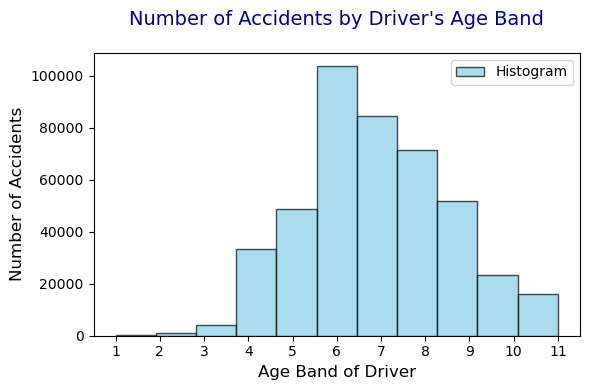

In [11]:
# 绘制年龄段分布直方图
plt.figure(figsize=(6, 4))
ax = cleaned_vehicle['age_band_of_driver'].hist(
    bins=11, color='skyblue', edgecolor='black', alpha=0.7, label='Histogram')

ax.set_title("Number of Accidents by Driver's Age Band", fontsize=14, color='darkblue', pad=20)
ax.set_xlabel("Age Band of Driver", fontsize=12, color='black')
ax.set_ylabel("Number of Accidents", fontsize=12, color='black')
ax.xaxis.set_major_locator(plt.MultipleLocator(1))  # 设置 x 轴刻度每 1 显示一次
#ax.grid(axis='y', linestyle='--', alpha=0.7)  # 添加水平网格线

# 移除网格线
ax.grid(False)

# 添加图例
plt.legend(fontsize=10)

# 调整布局并显示图表
plt.tight_layout()
plt.show()

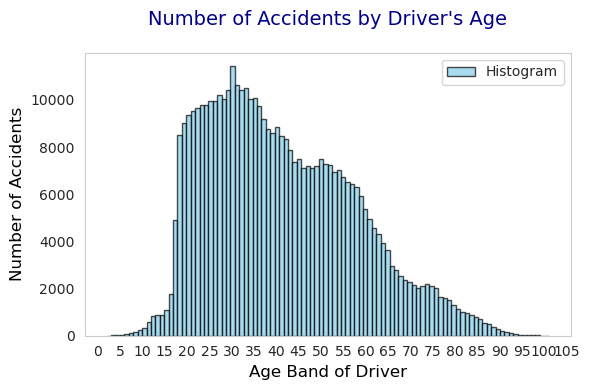

In [15]:
# 绘制年龄分布直方图
plt.figure(figsize=(6, 4))
ax = cleaned_vehicle['age_of_driver'].hist(
    bins=100, color='skyblue', edgecolor='black', alpha=0.7, label='Histogram')

ax.set_title("Number of Accidents by Driver's Age", fontsize=14, color='darkblue', pad=20)
ax.set_xlabel("Age Band of Driver", fontsize=12, color='black')
ax.set_ylabel("Number of Accidents", fontsize=12, color='black')
ax.xaxis.set_major_locator(plt.MultipleLocator(5))  # 设置 x 轴刻度每 1 显示一次
#ax.grid(axis='y', linestyle='--', alpha=0.7)  # 添加水平网格线

# 移除网格线
ax.grid(False)

# 添加图例
plt.legend(fontsize=10)

# 调整布局并显示图表
plt.tight_layout()
plt.show()

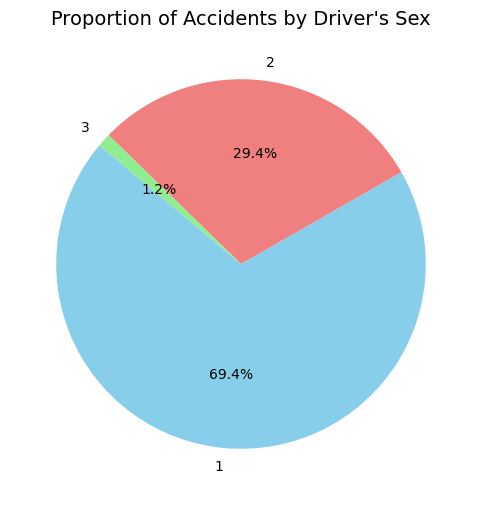

In [13]:
sex_of_driver_counts = cleaned_vehicle['sex_of_driver'].value_counts()

# 绘制饼图
plt.figure(figsize=(6, 6))
plt.pie(sex_of_driver_counts, 
        labels=sex_of_driver_counts.index, 
        autopct='%1.1f%%', 
        startangle=140, 
        colors=['skyblue', 'lightcoral', 'lightgreen'])
plt.title('Proportion of Accidents by Driver\'s Sex', fontsize=14)
plt.show()

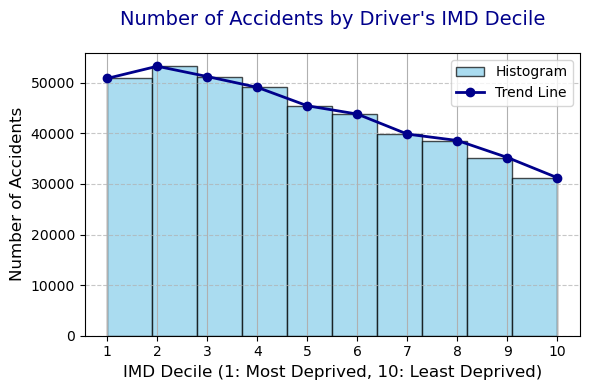

/tmp/ipykernel_67091/2814284049.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sn.countplot(


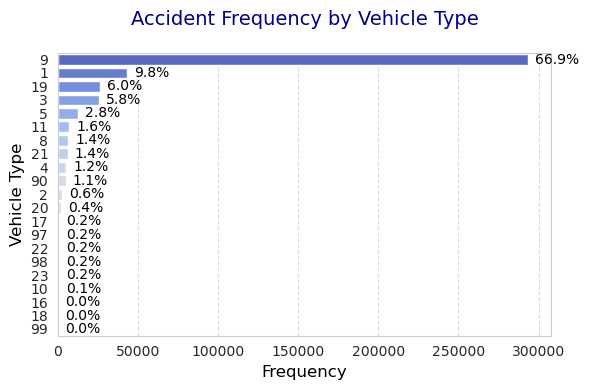

In [14]:
# 绘制直方图
plt.figure(figsize=(6, 4))
ax = cleaned_vehicle['driver_imd_decile'].hist(bins=10, color='skyblue', edgecolor='black', alpha=0.7, label='Histogram')

# 计算每个IMD分位数的事故数量
imd_counts = cleaned_vehicle['driver_imd_decile'].value_counts().sort_index()

# 叠加折线图
plt.plot(imd_counts.index, imd_counts.values, color='darkblue', marker='o', linestyle='-', linewidth=2, label='Trend Line')
plt.title("Number of Accidents by Driver's IMD Decile", fontsize=14, color='darkblue', pad=20)
plt.xlabel("IMD Decile (1: Most Deprived, 10: Least Deprived)", fontsize=12, color='black')
plt.ylabel("Number of Accidents", fontsize=12, color='black')
plt.xticks(range(1, 11))  # 显示1-10的刻度
plt.grid(axis='y', linestyle='--', alpha=0.7)  # 添加网格线
plt.legend(fontsize=10)  # 添加图例

plt.tight_layout()
plt.show()


# 设置图表样式
sn.set_style("whitegrid")

plt.figure(figsize=(6, 4))
ax = sn.countplot(
    data=cleaned_vehicle, 
    y='vehicle_type', 
    order=cleaned_vehicle['vehicle_type'].value_counts().index, 
    palette="coolwarm"
)

# 计算总数
total = len(cleaned_vehicle)

# 添加百分比标签
for p in ax.patches:
    width = p.get_width()
    ax.text(
        width + total * 0.01,  # 微调位置
        p.get_y() + p.get_height() / 2., 
        f'{width / total:.1%}', 
        va="center", 
        fontsize=10, 
        color='black'
    )

# 设置标题和标签
plt.title('Accident Frequency by Vehicle Type', fontsize=14, color='darkblue', pad=20)
plt.ylabel('Vehicle Type', fontsize=12, color='black')
plt.xlabel('Frequency', fontsize=12, color='black')

# 调整网格线样式
ax.xaxis.grid(True, linestyle='--', alpha=0.7)
ax.yaxis.grid(False)  # 关闭 y 轴的网格线

# 优化图表布局
plt.tight_layout()

# 显示图表
plt.show()